In [27]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as pyplot
import quandl
import math
import openpyxl
%matplotlib inline

In [28]:
def variance_calculator(series,series_average,win_len):
    sma   = win_len
    temp  = series.subtract(series_average)
    temp2 = temp.apply(lambda x:x**2)
    temp3 = temp2.rolling(sma-1).mean()
    sigma = temp3.apply(lambda x:math.sqrt(x))
    return sigma

In [29]:
key = 'xioC_P2K4MEszs4RLyBM'
start_date = '2014-12-12'
data1 = quandl.get("CHRIS/CME_SP1", authtoken = key, start_date = start_date)
declining = quandl.get("URC/NYSE_DEC", authtoken = key, start_date = start_date)
advancing = quandl.get("URC/NYSE_ADV", authtoken = key, start_date = start_date)
adv_vol   = quandl.get("URC/NYSE_ADV_VOL", authtoken = key, start_date = start_date)
dec_vol   = quandl.get("URC/NYSE_DEC_VOL", authtoken = key, start_date = start_date)

In [30]:
data = declining
data['declining'] = declining['Numbers of Stocks']
data['advancing'] = advancing['Numbers of Stocks']
data['dec_vol']   = dec_vol['Numbers of Stocks']
data['adv_vol']   = adv_vol['Numbers of Stocks']
merged = data.join(data1)
merged = merged.fillna(method = 'ffill') # Fill your data wisely to get better results
data = merged

In [35]:
global sma = 22        # moving average window length
global k = 1.5         # k*sigma from moving average(bollinger bands)
global l = 2           # l*sigma from moving average(bollinger bands)

SyntaxError: invalid syntax (<ipython-input-35-099e525feeec>, line 1)

In [36]:
def generate_trade_xls(data):
    
    pro = 0
    flag = 1
    buy_flag = False
    sell_flag = False
    transaction_start_price = 0
    abs_SL = 25 # absolute stoploss variable
    mtm  = list()
    order_details = list()
    order = list()
    profit = list()
    buy_sell = list()
    stoploss = list()
    trade_cause = list()
    
    tem1 = data['advancing'].divide(data['declining'])
    tem2 = data['adv_vol'].divide(data['dec_vol'])
    tem = tem1.divide(tem2)
    data['TRIN'] = tem
    data['TRIN'] = data['TRIN'].apply(lambda x:math.log(x))
    data['future'] = data['Last']
    data.to_csv('tempr_data.csv')
    data = pd.read_csv('tempr_data.csv')
    
    data['mAvg'] = data['TRIN'].rolling(sma).mean()
    data['TRIN_prev'] = data["TRIN"].shift(1)
    data.to_csv('tempr_data.csv')
    data = pd.read_csv('tempr_data.csv')
    
    sigma = variance_calculator(data['TRIN'],data['mAvg'],sma)
    k_sigma = k * sigma
    l_sigma = l * sigma

    data['UBB'] = data['mAvg'].add(k_sigma)
    data['LBB'] = data['mAvg'].subtract(k_sigma)
    data['USL'] = data['UBB'].add(l_sigma)
    data['LSL'] = data['LBB'].subtract(l_sigma)
    
    data['order'] = pd.Series()
    s = data['TRIN'].size
    
    for i in range(s):
        pro = 0
        future_cost = data['future'][i]
        trin = data['TRIN'][i]
        trin_prev = data['TRIN_prev'][i]
        lbb = data['LBB'][i]
        ubb = data['UBB'][i]
        mAvg = data['mAvg'][i]
        usl = data['USL'][i]
        lsl = data['LSL'][i]

        UBB_cross = (trin > ubb) and (trin_prev < ubb)
        LBB_cross = (trin < lbb) and (trin_prev < lbb)
        mAvg_cross_up = (trin > mAvg) and (trin_prev < mAvg)
        mAvg_cross_down = (trin < mAvg) and (trin_prev > mAvg)
        USL_cross = (trin > usl) and (trin_prev < usl)
        LSL_cross = (trin < lsl) and (trin_prev < lsl)

        if(UBB_cross and (not buy_flag) and flag == 1):
            flag = 0
            buy_flag = True
            sell_flag = False
            transaction_start_price = future_cost
            order_details = [1,"Buy","UBB crossed","0","position token"]

        elif(LBB_cross and (not sell_flag) and flag == 1):
            flag = 0
            buy_flag = False
            sell_flag = True
            transaction_start_price = future_cost
            order_details = [-1,"Sell","LBB crossed","0","position token"]

        # TO CLOSE SELL POSITIONS
        elif(mAvg_cross_up and flag==0 and (not buy_flag)):
            flag = 1
            buy_flag = False
            sell_flag = False
            pro = future_cost - transaction_start_price
            order_details = [1,"Buy","mAvg crossed","0","position close"]

        elif(LSL_cross and flag==0 and (not buy_flag)):
            flag = 1
            buy_flag = False
            sell_flag = False
            pro = future_cost - transaction_start_price
            order_details = [1,"Buy","LSL crossed","stoploss executed","position closed"]

        elif((future_cost - transaction_start_price) > abs_SL and flag==0 and (not buy_flag)):
            flag = 1
            buy_flag = False
            sell_flag = False
            pro = future_cost - transaction_start_price
            order_details = [1,"Buy","LSB crossed","stoploss executed","position closed"]

        # TO CLOSE BUY POSITIONS 
        elif(mAvg_cross_down and flag==0 and (not sell_flag)):
            flag = 1
            buy_flag = False
            sell_flag = False
            pro = -(future_cost - transaction_start_price)
            order_details = [-1,"Sell","mAvg crossed","0","position close"]

        elif(USL_cross and flag==0 and (not sell_flag)):
            flag = 1
            buy_flag = False
            sell_flag = False
            pro = -(future_cost - transaction_start_price)
            order_details = [-1,"Sell","USB crossed","stoploss executed","position closed"]

        elif((-future_cost + transaction_start_price) > abs_SL and flag==0 and (not sell_flag)):
            flag = 1
            buy_flag = False
            sell_flag = False
            pro = -(future_cost - transaction_start_price)
            order_details = [-1,"Sell","LSB crossed","stoploss executed_abs","position closed"]

        else:
            if(buy_flag==0 and sell_flag==0): tempo = "0"
            else:
                if(buy_flag == 1 and sell_flag == 0): tempo = (data['future'][i] - transaction_start_price) * 500
                if(buy_flag == 0 and sell_flag == 1): tempo = (-data['future'][i] + transaction_start_price) * 500

            order_details = [0,"No trade","no trade","0",tempo]

        profit.append(pro)
        order.append(order_details[0])
        buy_sell.append(order_details[1])
        trade_cause.append(order_details[2])
        stoploss.append(order_details[3])
        mtm.append(order_details[4])

    data['placed_order'] = pd.Series(order)
    data['cost'] = -(data['placed_order'].multiply(data['future'])) * 500
    data['out']  = data['cost'].cumsum()
    data['buy_sell'] = pd.Series(buy_sell)
    data['profit'] = -pd.Series(profit) * 500
    data['stoploss'] = pd.Series(stoploss)
    data['trade_cause'] = pd.Series(trade_cause)
    data['mtm'] = pd.Series(mtm)
    
    output = pd.DataFrame()
    output['date'] = data['Date']
    output['close'] = data['future']
    output['TRIN'] = data['TRIN']
    output['placed_order'] = data['placed_order']
    output['buy_sell'] = data['buy_sell']
    output['trade_cause'] = data['trade_cause']
    output['PnL'] = data['profit']
    output['mtm'] = data['mtm']
    output['stoploss'] = data['stoploss']
    output['Cash Account'] = data['out']
    output.to_excel('TRIN_SL_output.xlsx', sheet_name='Sheet1')
    
    pyplot.plot(data['TRIN'])
    pyplot.plot(data['mAvg'])
    pyplot.plot(data['UBB'])
    pyplot.plot(data['LBB'])
    pyplot.show()
    
    return output

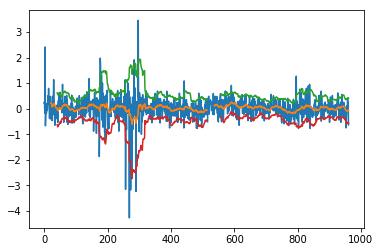

In [37]:
output = generate_trade_xls(data)

In [38]:
print("NET PROFIT :: " + str(output['PnL'].sum()))

NET PROFIT :: 18099.999999999676
